In [2]:
!pip install pybaselines
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 3.7 MB/s eta 0:00:00


Current data is shaped: (1250, 100, 514)


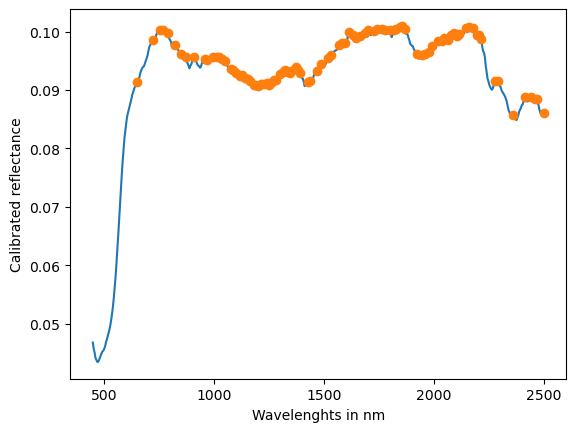

In [275]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 40
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

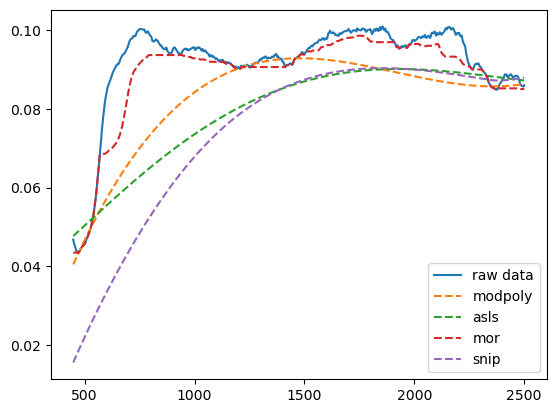

In [276]:
baseline_fitter = Baseline(wav_array,
                           check_finite=False)

bkg_1 = baseline_fitter.modpoly(curr_pixel, poly_order=3)[0]
bkg_2 = baseline_fitter.asls(curr_pixel, lam=1e7, p=0.02)[0]
bkg_3 = baseline_fitter.mor(curr_pixel, half_window=30)[0]
bkg_4 = baseline_fitter.snip(
    curr_pixel, max_half_window=40, decreasing=True, smooth_half_window=3
)[0]

plt.plot(wav_array, curr_pixel, label='raw data', lw=1.5)
# plt.plot(wav_array, true_baseline, lw=3, label='true baseline')
plt.plot(wav_array, bkg_1, '--', label='modpoly')
plt.plot(wav_array, bkg_2, '--', label='asls')
plt.plot(wav_array, bkg_3, '--', label='mor')
plt.plot(wav_array, bkg_4, '--', label='snip')

plt.legend()
plt.show()


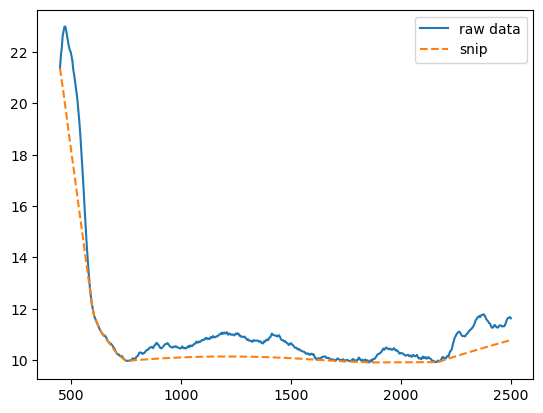

In [277]:
pix_inverse = 1 / curr_pixel 

baseline_fitter = Baseline(wav_array,
                           check_finite=False)

bkg_1 = baseline_fitter.modpoly(pix_inverse, poly_order=3)[0]
bkg_2 = baseline_fitter.asls(pix_inverse, lam=1e7, p=0.02)[0]
bkg_3 = baseline_fitter.mor(pix_inverse, half_window=30)[0]
bkg_4 = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0
)[0]

plt.plot(wav_array, pix_inverse, label='raw data', lw=1.5)
# plt.plot(wav_array, true_baseline, lw=3, label='true baseline')
# plt.plot(wav_array, bkg_1, '--', label='modpoly')
# plt.plot(wav_array, bkg_2, '--', label='asls')
# plt.plot(wav_array, bkg_3, '--', label='mor')
plt.plot(wav_array, bkg_4, '--', label='snip')

plt.legend()
plt.show()




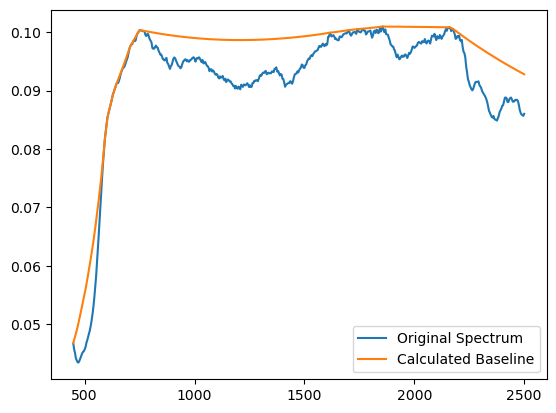

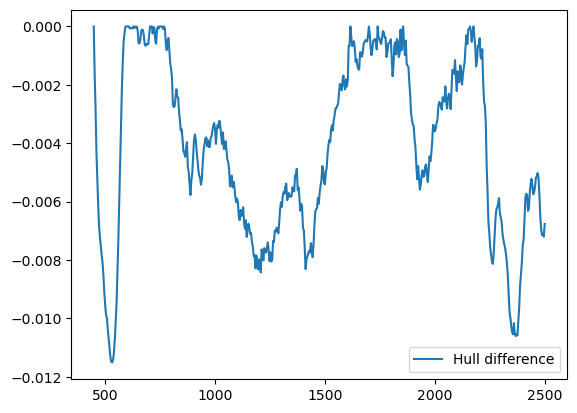

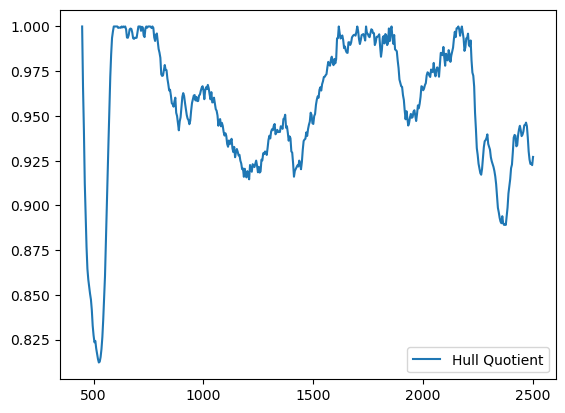

In [278]:
# Invert the data 
pix_inverse = 1 / curr_pixel 

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel-curr_baseline, label='Hull difference')
plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel/curr_baseline, label='Hull Quotient')
plt.legend()


In [73]:
# # !conda install astropy -y
# from astropy.modeling.functional_models import Fittable1DModel
# from astropy.modeling.fitting import LevMarLSQFitter
# import astropy.modeling.fitting
# import astropy.modeling.functional_models
# test = astropy.modeling.functional_models
# test = astropy.modeling.fitting
# test.LevMarLSQFitter

astropy.modeling.fitting.LevMarLSQFitter

In [83]:
# def sum_of_gaussians(x, amplitude1=1., mean1=0., sigma1=1.,
#                         amplitude2=1., mean2=1., sigma2=1.):
#     return (1. / (sigma1 * np.sqrt(2. * np.pi)) * np.exp(-0.5 * ((x - mean1) / sigma1)**2) +
#             1. / (sigma2 * np.sqrt(2. * np.pi)) * np.exp(-0.5 * ((x - mean2) / sigma2)**2))

# # Try fitting it

# m = Fittable1DModel(sum_of_gaussians)
# fit = LevMarLSQFitter(m)
# fit(wav_array, curr_pixel/curr_baseline)

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.plot(wav_array, curr_pixel/curr_baseline, 'o', color='k')
# ax.plot(wav_array, m(wav_array), color='r')
# # fig.savefig('data.png')

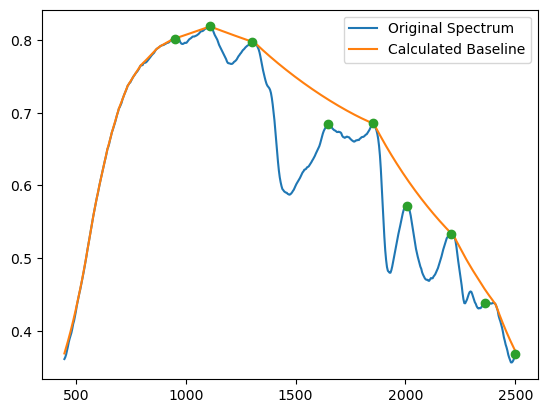

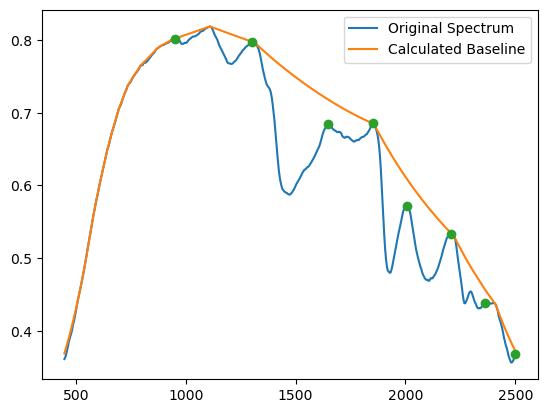

In [195]:
# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width=10,
                  distance = 10)[0]
peaks = np.append(peaks, curr_pixel.shape[0] -1)
peaks = peaks.astype(int)
# Append the end of the spectrum
# peaks = np.append(peaks, curr_pixel.shape[0]-1)



plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
# Check the peaks that we found earlier
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')
plt.legend()

skipped_peaks = []
for peak in peaks:
    if curr_pixel[peak] < curr_baseline[peak]:
        skipped_peaks.append(peak)
skipped_peaks = np.asarray(skipped_peaks).astype(int)
plt.figure()
plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
# Check the peaks that we found earlier
plt.plot(wav_array[skipped_peaks], curr_pixel[skipped_peaks], 'o')
plt.legend()

# Create a combined hull

NameError: name 'section_start' is not defined

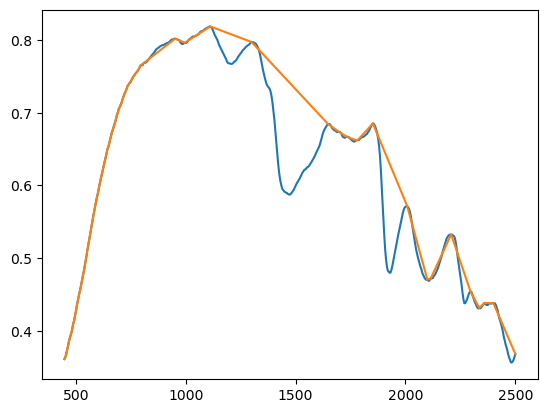

In [271]:
# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                 peaks - peaks[0])

concat_hull = np.concatenate((curr_pixel[0:peaks[0]],
                              prelim_hull))
    
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, concat_hull)

# Identify contiguous areas where the baseline falls below the spectrum
# overlap_below = wav_array[concat_hull < curr_pixel]
overlap_inds = concat_hull*1.01 < (curr_pixel)

this_seg = curr_pixel[overlap_inds]



# wav_array[overlap_below]
interm_peaks = find_peaks(this_seg,
           width=5)[0] 
                  # distance = 10)[0]
    
interm_peaks = np.argmax(this_seg)
    
addl_peaks = np.argmax(overlap_inds) + interm_peaks

import numpy as np
from scipy.signal import argrelextrema

# Compute the relative maxima of 'y'
maxima = argrelextrema(this_seg, np.greater)
addl_peaks = np.argmax(overlap_inds) + maxima
addl_peaks = addl_peaks[0]


x = wav_array
y = curr_pixel

# Initialize the maximum value and index
max_value = -np.inf
max_index = -1

# Iterate over the data within the section
for i in range(len(this_seg)):
    if section_start <= this_seg[i] <= section_end:
        if y[i] > max_value:
            max_value = y[i]
            max_index = i

max_index

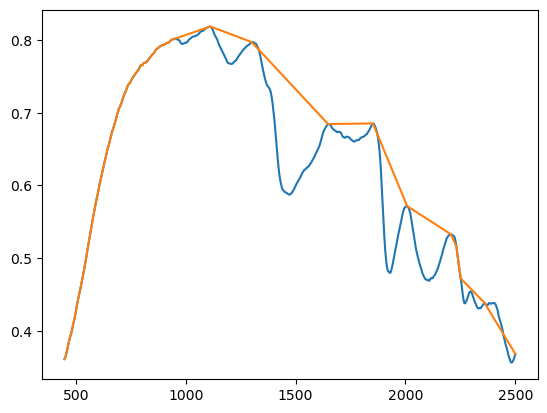

In [265]:
all_peaks = np.sort(np.unique(np.concatenate((peaks, addl_peaks))))

prelim_hull = interpolate_linear(curr_pixel[all_peaks[0]:],
                                 all_peaks - all_peaks[0])

concat_hull = np.concatenate((curr_pixel[0:all_peaks[0]],
                              prelim_hull))
    
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, concat_hull)

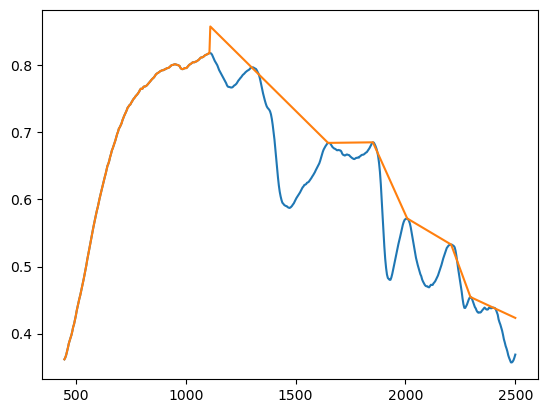

In [166]:
curr_baseline_max = np.argmax(curr_pixel)
effective_segs = skipped_peaks[skipped_peaks >= curr_baseline_max]

# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


# for i,k in enumerate(effective_segs):

k = effective_segs[0]
effective_segs[1]

prelim_hull = interpolate_linear(curr_pixel[curr_baseline_max:],
                                 effective_segs - curr_baseline_max)

concat_hull = np.concatenate((curr_pixel[0:curr_baseline_max], prelim_hull))
    
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, concat_hull)
